In [ ]:
!pip install gdown

In [2]:
!gdown --id 1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF

Downloading...
From: https://drive.google.com/uc?id=1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF
To: /content/archive.zip
650MB [00:10, 62.4MB/s]


In [3]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.6 s, sys: 941 ms, total: 4.54 s
Wall time: 4.76 s


In [4]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [5]:
import os
IMAGE_PATH="./scenery"
file_names=os.listdir(IMAGE_PATH)
print(f"number of images: {len(file_names)}")

number of images: 4319


800 800
(4096,)


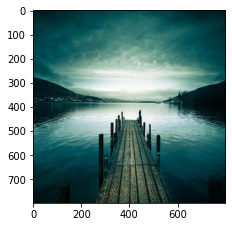

In [6]:
import numpy as np
import cv2
from PIL import Image
query_image_pillow=Image.open(f'{IMAGE_PATH}/00000000_(2).jpg')
width, height = query_image_pillow.size
print(width, height)
query_image=cv2.imread(f'{IMAGE_PATH}/00000000_(2).jpg')
query_hist_combined=cv2.calcHist([query_image],[0,1,2],None,[16,16,16],[0,256,0,256,0,256])
query_hist_combined = cv2.normalize(query_hist_combined, query_hist_combined).flatten()
print(query_hist_combined.shape)
show_images([np.array(query_image_pillow)])

In [7]:
file_names=os.listdir(IMAGE_PATH)
hists=[]
for file_name in file_names:
  img=cv2.imread(f'{IMAGE_PATH}/{file_name}')
  hist_combined=cv2.calcHist([img],[0,1,2],None,[16,16,16],[0,256,0,256,0,256])
  hist_combined = cv2.normalize(hist_combined, hist_combined).flatten()
  hists.append({"hist":hist_combined,"file_name":file_name})

In [8]:
%%time
found_images=[]
for hist in hists:
  similarity=cv2.compareHist(query_hist_combined,hist["hist"],cv2.HISTCMP_INTERSECT)
  found_images.append({"similarity":similarity,"file_name":hist["file_name"]})
found_images.sort(key=lambda item: item["similarity"],reverse=True)
found_images=found_images[:10]

CPU times: user 27.6 ms, sys: 2.02 ms, total: 29.6 ms
Wall time: 31.2 ms


In [9]:
print(found_images)
images_np=[]
found_images_filenames=list(map(lambda el: el["file_name"],found_images))
for image_filename in found_images_filenames:
  images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_filename}')))

[{'similarity': 5.941470754310103, 'file_name': '00000032.jpg'}, {'similarity': 5.941470754310103, 'file_name': '00000000_(2).jpg'}, {'similarity': 3.7332527190837936, 'file_name': '00000010_(5).jpg'}, {'similarity': 3.7332527190837936, 'file_name': '00000001_(2).jpg'}, {'similarity': 3.7312281990125484, 'file_name': '00000015.jpg'}, {'similarity': 3.447080567316334, 'file_name': '00000028_(2).jpg'}, {'similarity': 3.3780403354630835, 'file_name': '00000046.jpg'}, {'similarity': 3.3780403354630835, 'file_name': '00000007_(2).jpg'}, {'similarity': 3.269465442122055, 'file_name': '00000019_(6).jpg'}, {'similarity': 3.121017268457763, 'file_name': '00000003_(5).jpg'}]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


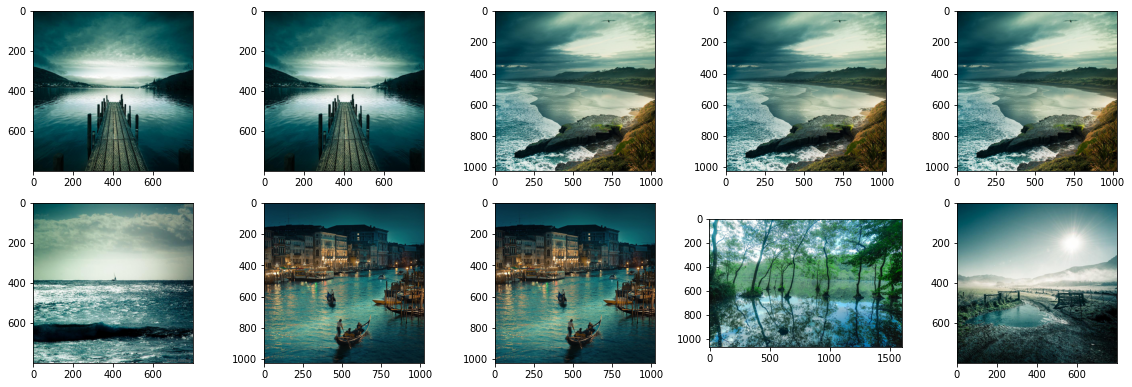

In [10]:
show_images(np.array(images_np))

In [11]:
from sklearn.neighbors import NearestNeighbors
hists_list=list(map(lambda el: el['hist'],hists))
knn = NearestNeighbors(n_neighbors=10,algorithm='brute',metric='euclidean')
knn.fit(hists_list)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [12]:
%%time
distances,indices= knn.kneighbors([query_hist_combined], return_distance=True)

CPU times: user 88.9 ms, sys: 37.9 ms, total: 127 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


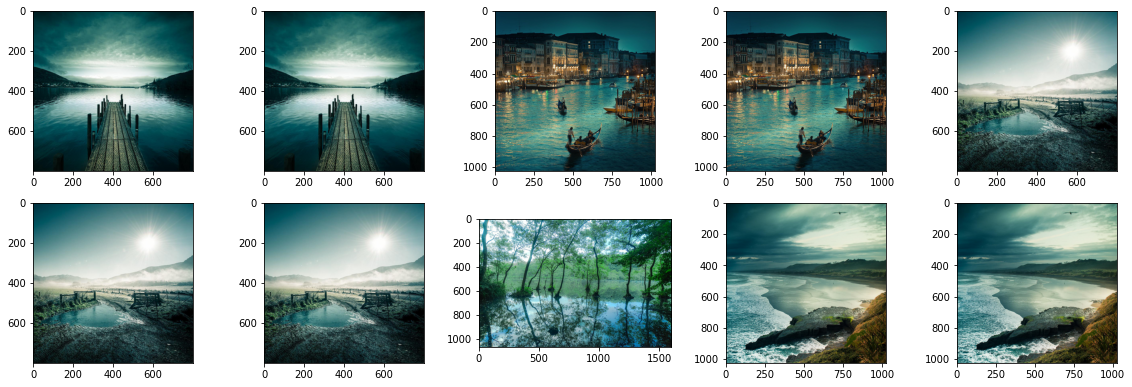

In [13]:
indices=indices[0]
images_np_knn=[]
for idx in indices:
  images_np_knn.append(np.array(Image.open(f'{IMAGE_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_knn))

In [14]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.5.1-cp37-cp37m-linux_x86_64.whl size=1296773 sha256=c3806e9ec74f9f22acffadc8ccda244e90bae47df26682665e1d1e7e26cec9f5
  Stored in directory: /root/.cache/pip/wheels/46/7b/98/44c3a8a284506a54993f0b321e4a32a0c9e69215bbb72feff5
Successfully built hnswlib


In [15]:
import hnswlib
dim=4096
index = hnswlib.Index(space='l2', dim=4096)
index.init_index(max_elements=10000, ef_construction=100, M=16)
data = np.array(hists_list)
index.add_items(data)

In [17]:
%%time
labels, distances = index.knn_query(query_hist_combined, k = 10)

CPU times: user 528 µs, sys: 0 ns, total: 528 µs
Wall time: 312 µs


[3297 4209 2136 4164 1755 1851 3556  246 1427 3992]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


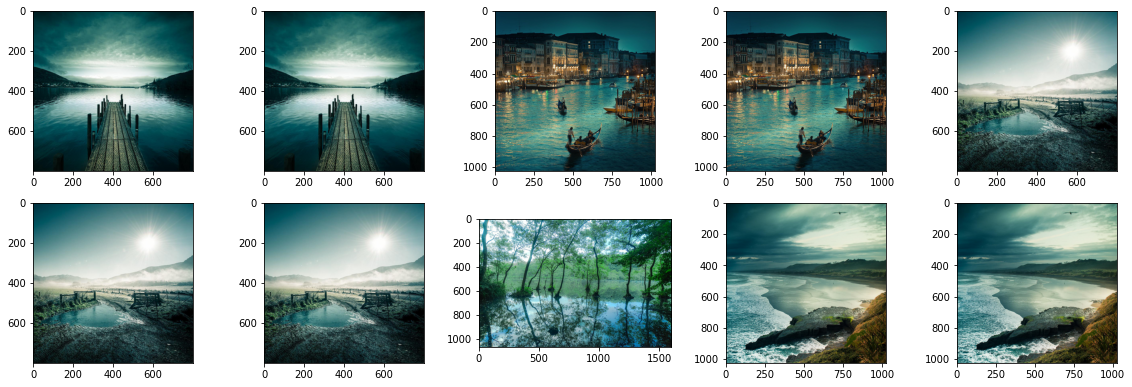

In [18]:
images_np_hnsw=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw.append(np.array(Image.open(f'{IMAGE_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw))

5.320865959729417


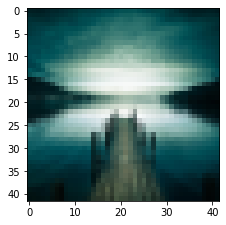

In [19]:
query_image_resized=np.array(query_image_pillow.resize((width//19, height//19)))
show_images([np.array(query_image_resized)])
query_image_resized = cv2.cvtColor(query_image_resized, cv2.COLOR_RGB2BGR)
query_hist_resized=cv2.calcHist([query_image_resized],[0,1,2],None,[16,16,16],[0,256,0,256,0,256])
query_hist_resized = cv2.normalize(query_hist_resized, query_hist_resized).flatten()
print(cv2.compareHist(query_hist_combined,query_hist_resized,cv2.HISTCMP_INTERSECT))

5.452956081746379


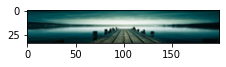

In [20]:
query_image_resized_2=np.array(query_image_pillow.resize((width//4, height//23)))
show_images([np.array(query_image_resized_2)])
query_image_resized_2 = cv2.cvtColor(query_image_resized_2, cv2.COLOR_RGB2BGR)
query_hist_resized_2=cv2.calcHist([query_image_resized_2],[0,1,2],None,[16,16,16],[0,256,0,256,0,256])
query_hist_resized_2 = cv2.normalize(query_hist_resized_2, query_hist_resized_2).flatten()
print(cv2.compareHist(query_hist_combined,query_hist_resized_2,cv2.HISTCMP_INTERSECT))

3.402340337640453


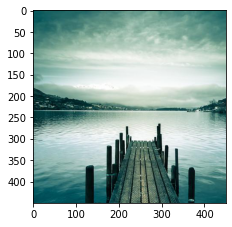

In [21]:
crop_rectangle = (150, 150, 600, 600)
query_image_cropped = np.array(query_image_pillow.crop(crop_rectangle))
show_images([np.array(query_image_cropped)])
query_image_cropped = cv2.cvtColor(query_image_cropped, cv2.COLOR_RGB2BGR)
query_hist_cropped=cv2.calcHist([query_image_cropped],[0,1,2],None,[16,16,16],[0,256,0,256,0,256])
query_hist_cropped = cv2.normalize(query_hist_cropped, query_hist_cropped).flatten()
print(cv2.compareHist(query_hist_combined,query_hist_cropped,cv2.HISTCMP_INTERSECT))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


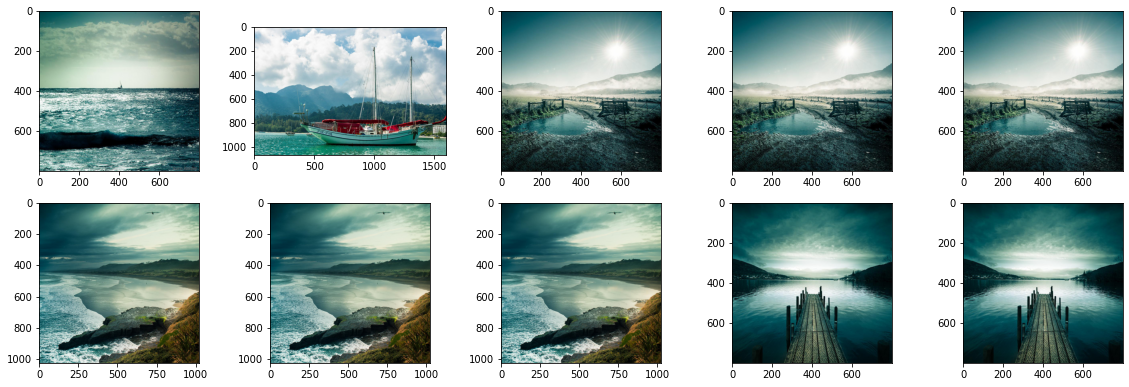

In [22]:
distances,indices= knn.kneighbors([query_hist_cropped], return_distance=True)
indices=indices[0]
images_np_knn=[]
for idx in indices:
  images_np_knn.append(np.array(Image.open(f'{IMAGE_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_knn))